In [16]:
!pip install shap


You should consider upgrading via the 'c:\users\souri\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

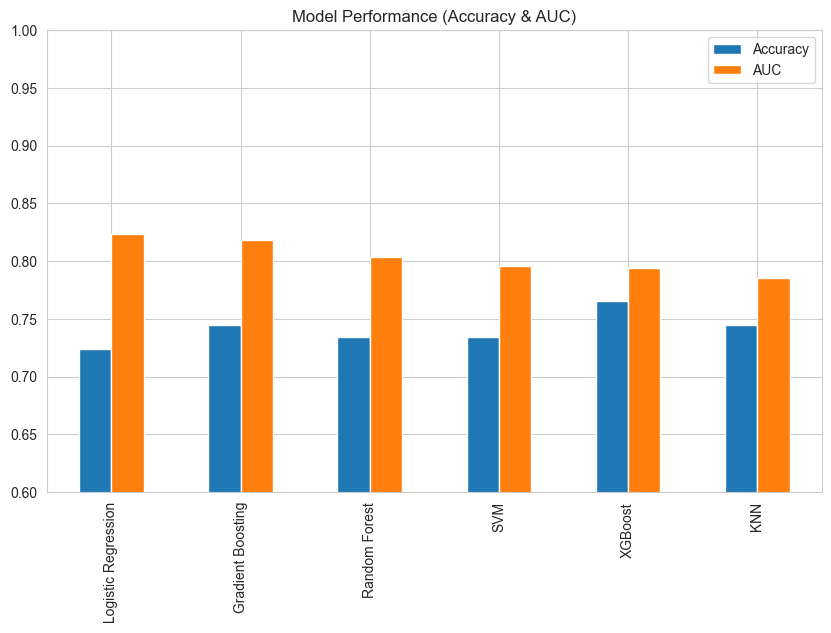

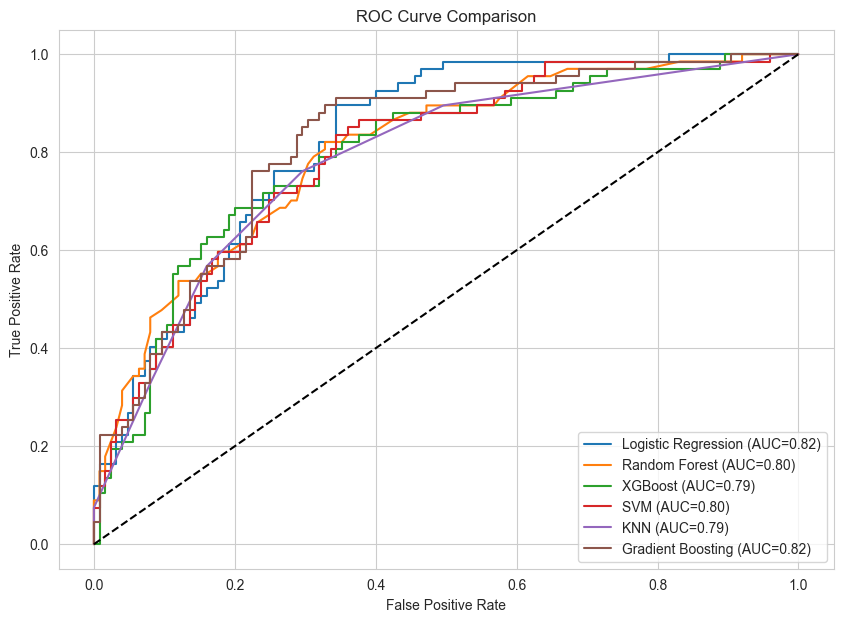

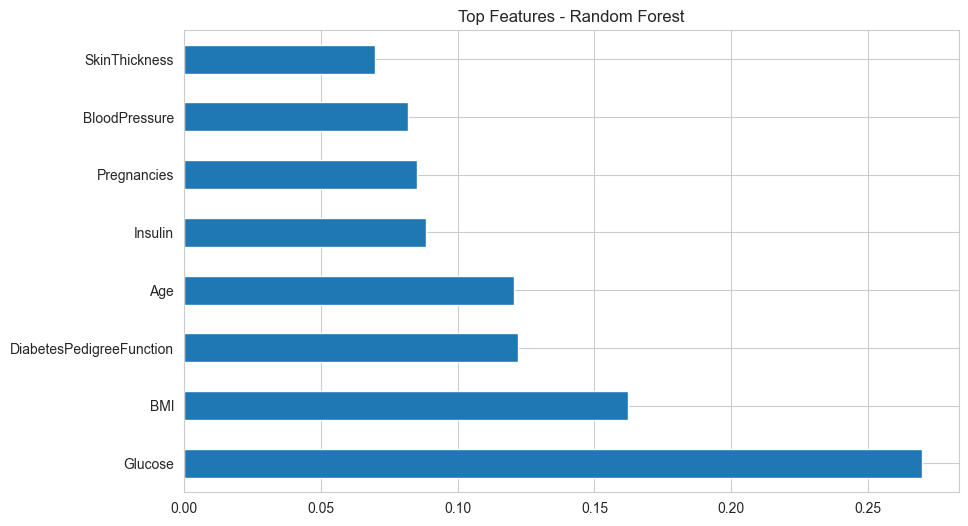

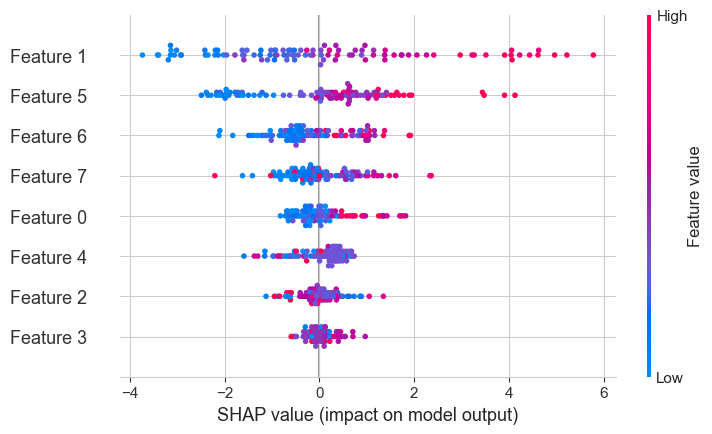


 Cross-Validation Scores (5-fold)
Random Forest: Mean AUC = 0.831
XGBoost: Mean AUC = 0.801
Gradient Boosting: Mean AUC = 0.830


In [17]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

#  Load Dataset
df = pd.read_csv("diabetes.csv")

#  Preview
print(df.head())
print(df.info())
print(df.describe())

#  Replace 0s with NaN in specific columns (since 0 is not valid for them)
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Fill missing values with median (could also use mean or KNN Imputer for better accuracy)
df.fillna(df.median(), inplace=True)

#  Data Splitting
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

#  Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=42)

#  Models to train
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

#  Model Training Loop
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    results[name] = {"Accuracy": acc, "AUC": auc}
    print(f"\n {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

#  AUC Comparison
result_df = pd.DataFrame(results).T.sort_values(by="AUC", ascending=False)
result_df.plot(kind="bar", figsize=(10,6), title="Model Performance (Accuracy & AUC)", ylim=(0.6, 1.0))
plt.grid(True)
plt.show()

#  ROC Curve 
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_probs):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
feat_imp = pd.Series(models["Random Forest"].feature_importances_, index=df.columns[:-1])
feat_imp.nlargest(10).plot(kind='barh', title="Top Features - Random Forest")
plt.show()

explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test[:100])  # limit to 100 samples to reduce load
shap.plots.beeswarm(shap_values)

print("\n Cross-Validation Scores (5-fold)")
for name in ["Random Forest", "XGBoost", "Gradient Boosting"]:
    scores = cross_val_score(models[name], X_scaled, y, cv=5, scoring='roc_auc')
    print(f"{name}: Mean AUC = {scores.mean():.3f}")


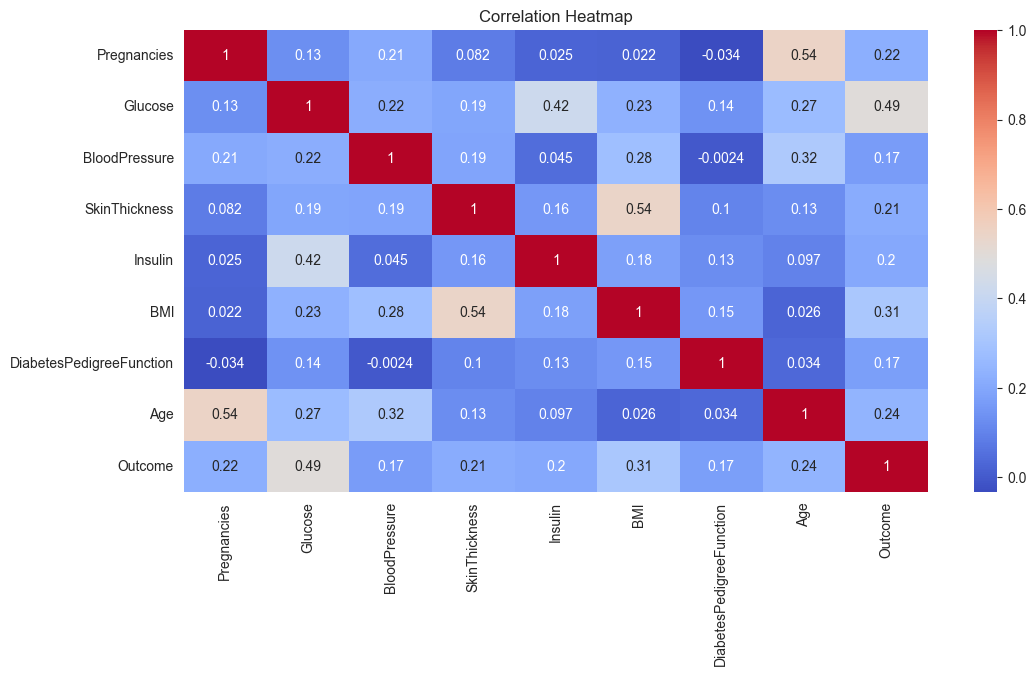

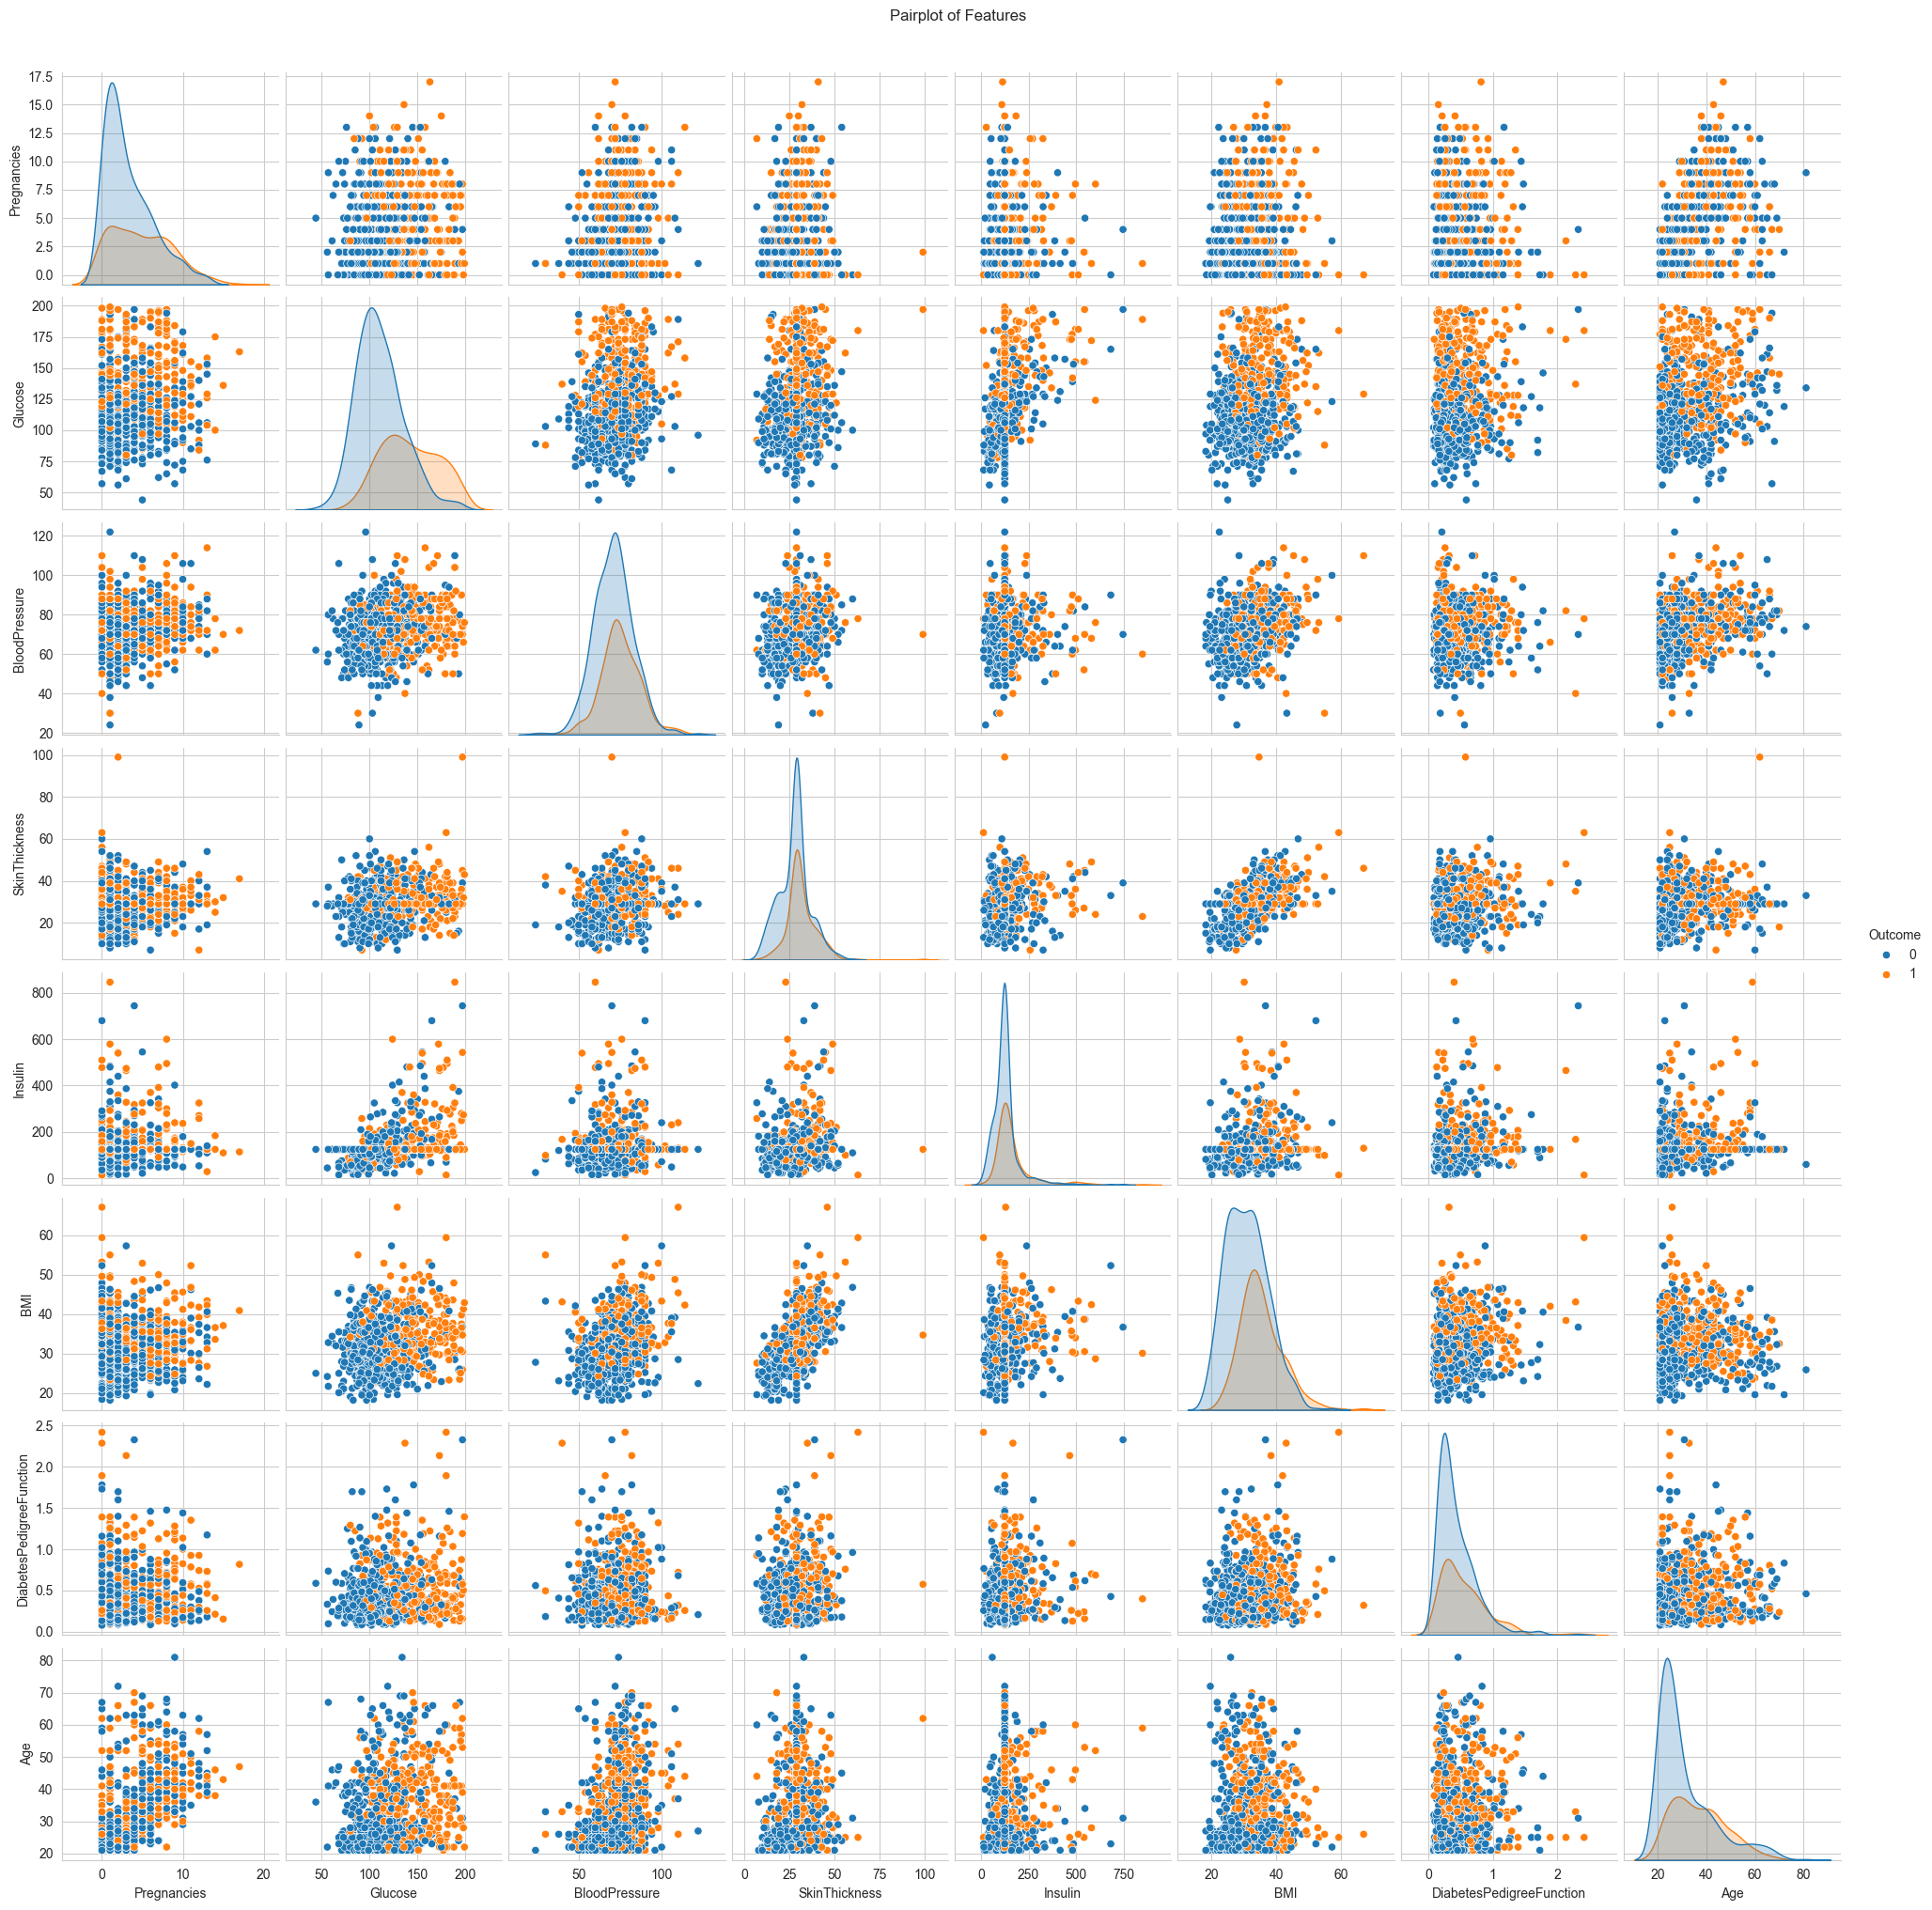


 Logistic Regression
Confusion Matrix:
 [[105  20]
 [ 33  34]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       125
           1       0.63      0.51      0.56        67

    accuracy                           0.72       192
   macro avg       0.70      0.67      0.68       192
weighted avg       0.72      0.72      0.72       192


 Random Forest
Confusion Matrix:
 [[103  22]
 [ 29  38]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       125
           1       0.63      0.57      0.60        67

    accuracy                           0.73       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.73      0.73       192


 XGBoost
Confusion Matrix:
 [[105  20]
 [ 25  42]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       125
           1       0.68      0.63      0.65        67

    accu

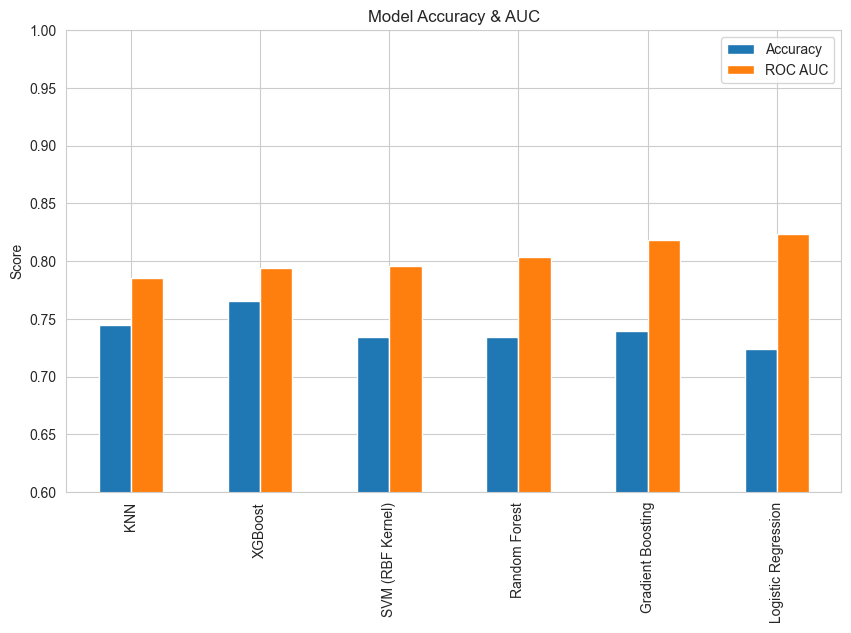

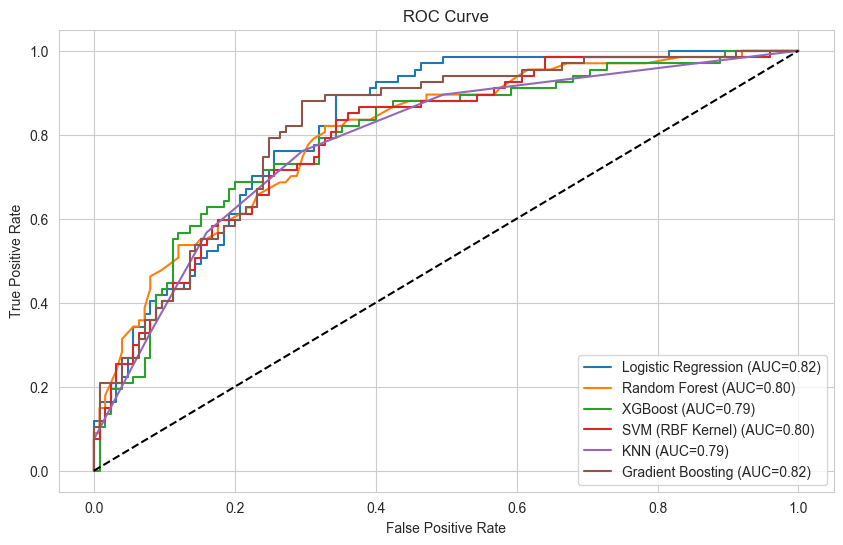

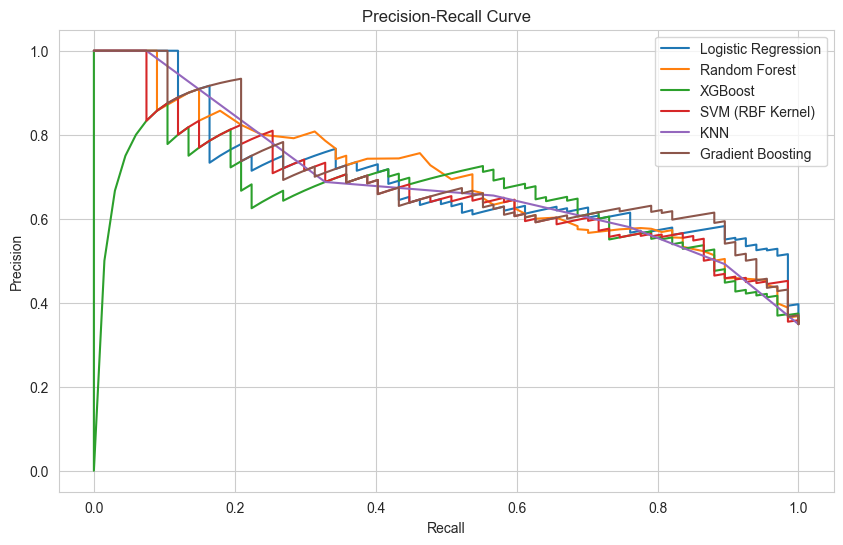

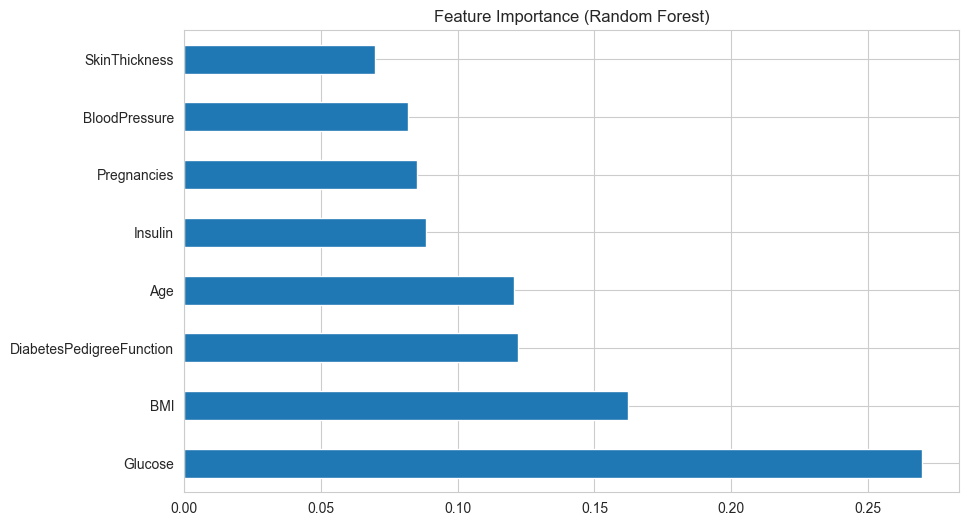


 Cross-validation AUC (5-fold):
Random Forest: Mean AUC = 0.831 | Std = 0.031
XGBoost: Mean AUC = 0.801 | Std = 0.033
Gradient Boosting: Mean AUC = 0.831 | Std = 0.026


In [18]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#  Loading Dataset
df = pd.read_csv('diabetes.csv')

#  Cleaing  Data
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

#  EDA
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Pairplot
sns.pairplot(df, hue="Outcome", diag_kind="kde")
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

#  Features & Target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

#  Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM (RBF Kernel)": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

# Train & Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"Accuracy": acc, "ROC AUC": auc}
    
    print(f"\n {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Model Comparison
pd.DataFrame(results).T.sort_values(by="ROC AUC").plot(kind="bar", figsize=(10,6), ylim=(0.6, 1.0), title="Model Accuracy & AUC", grid=True)
plt.ylabel("Score")
plt.show()

# ROC Curves
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
    
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
feat_imp = pd.Series(models["Random Forest"].feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind="barh", title="Feature Importance (Random Forest)")
plt.show()

# Cross-validation
print("\n Cross-validation AUC (5-fold):")
for name in ["Random Forest", "XGBoost", "Gradient Boosting"]:
    scores = cross_val_score(models[name], X_scaled, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5))
    print(f"{name}: Mean AUC = {scores.mean():.3f} | Std = {scores.std():.3f}")



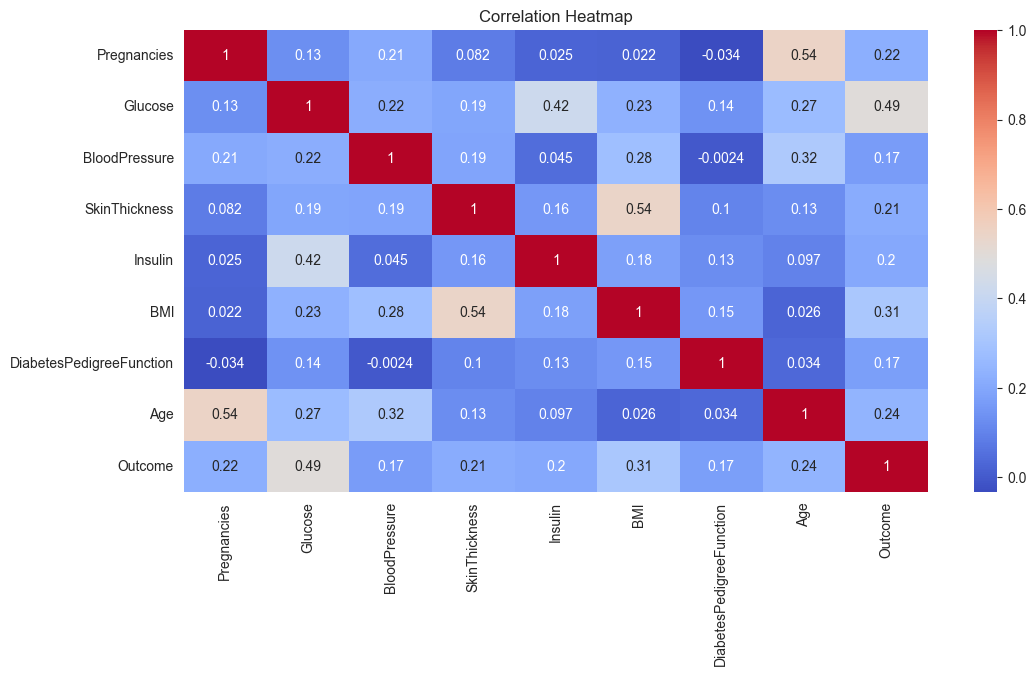

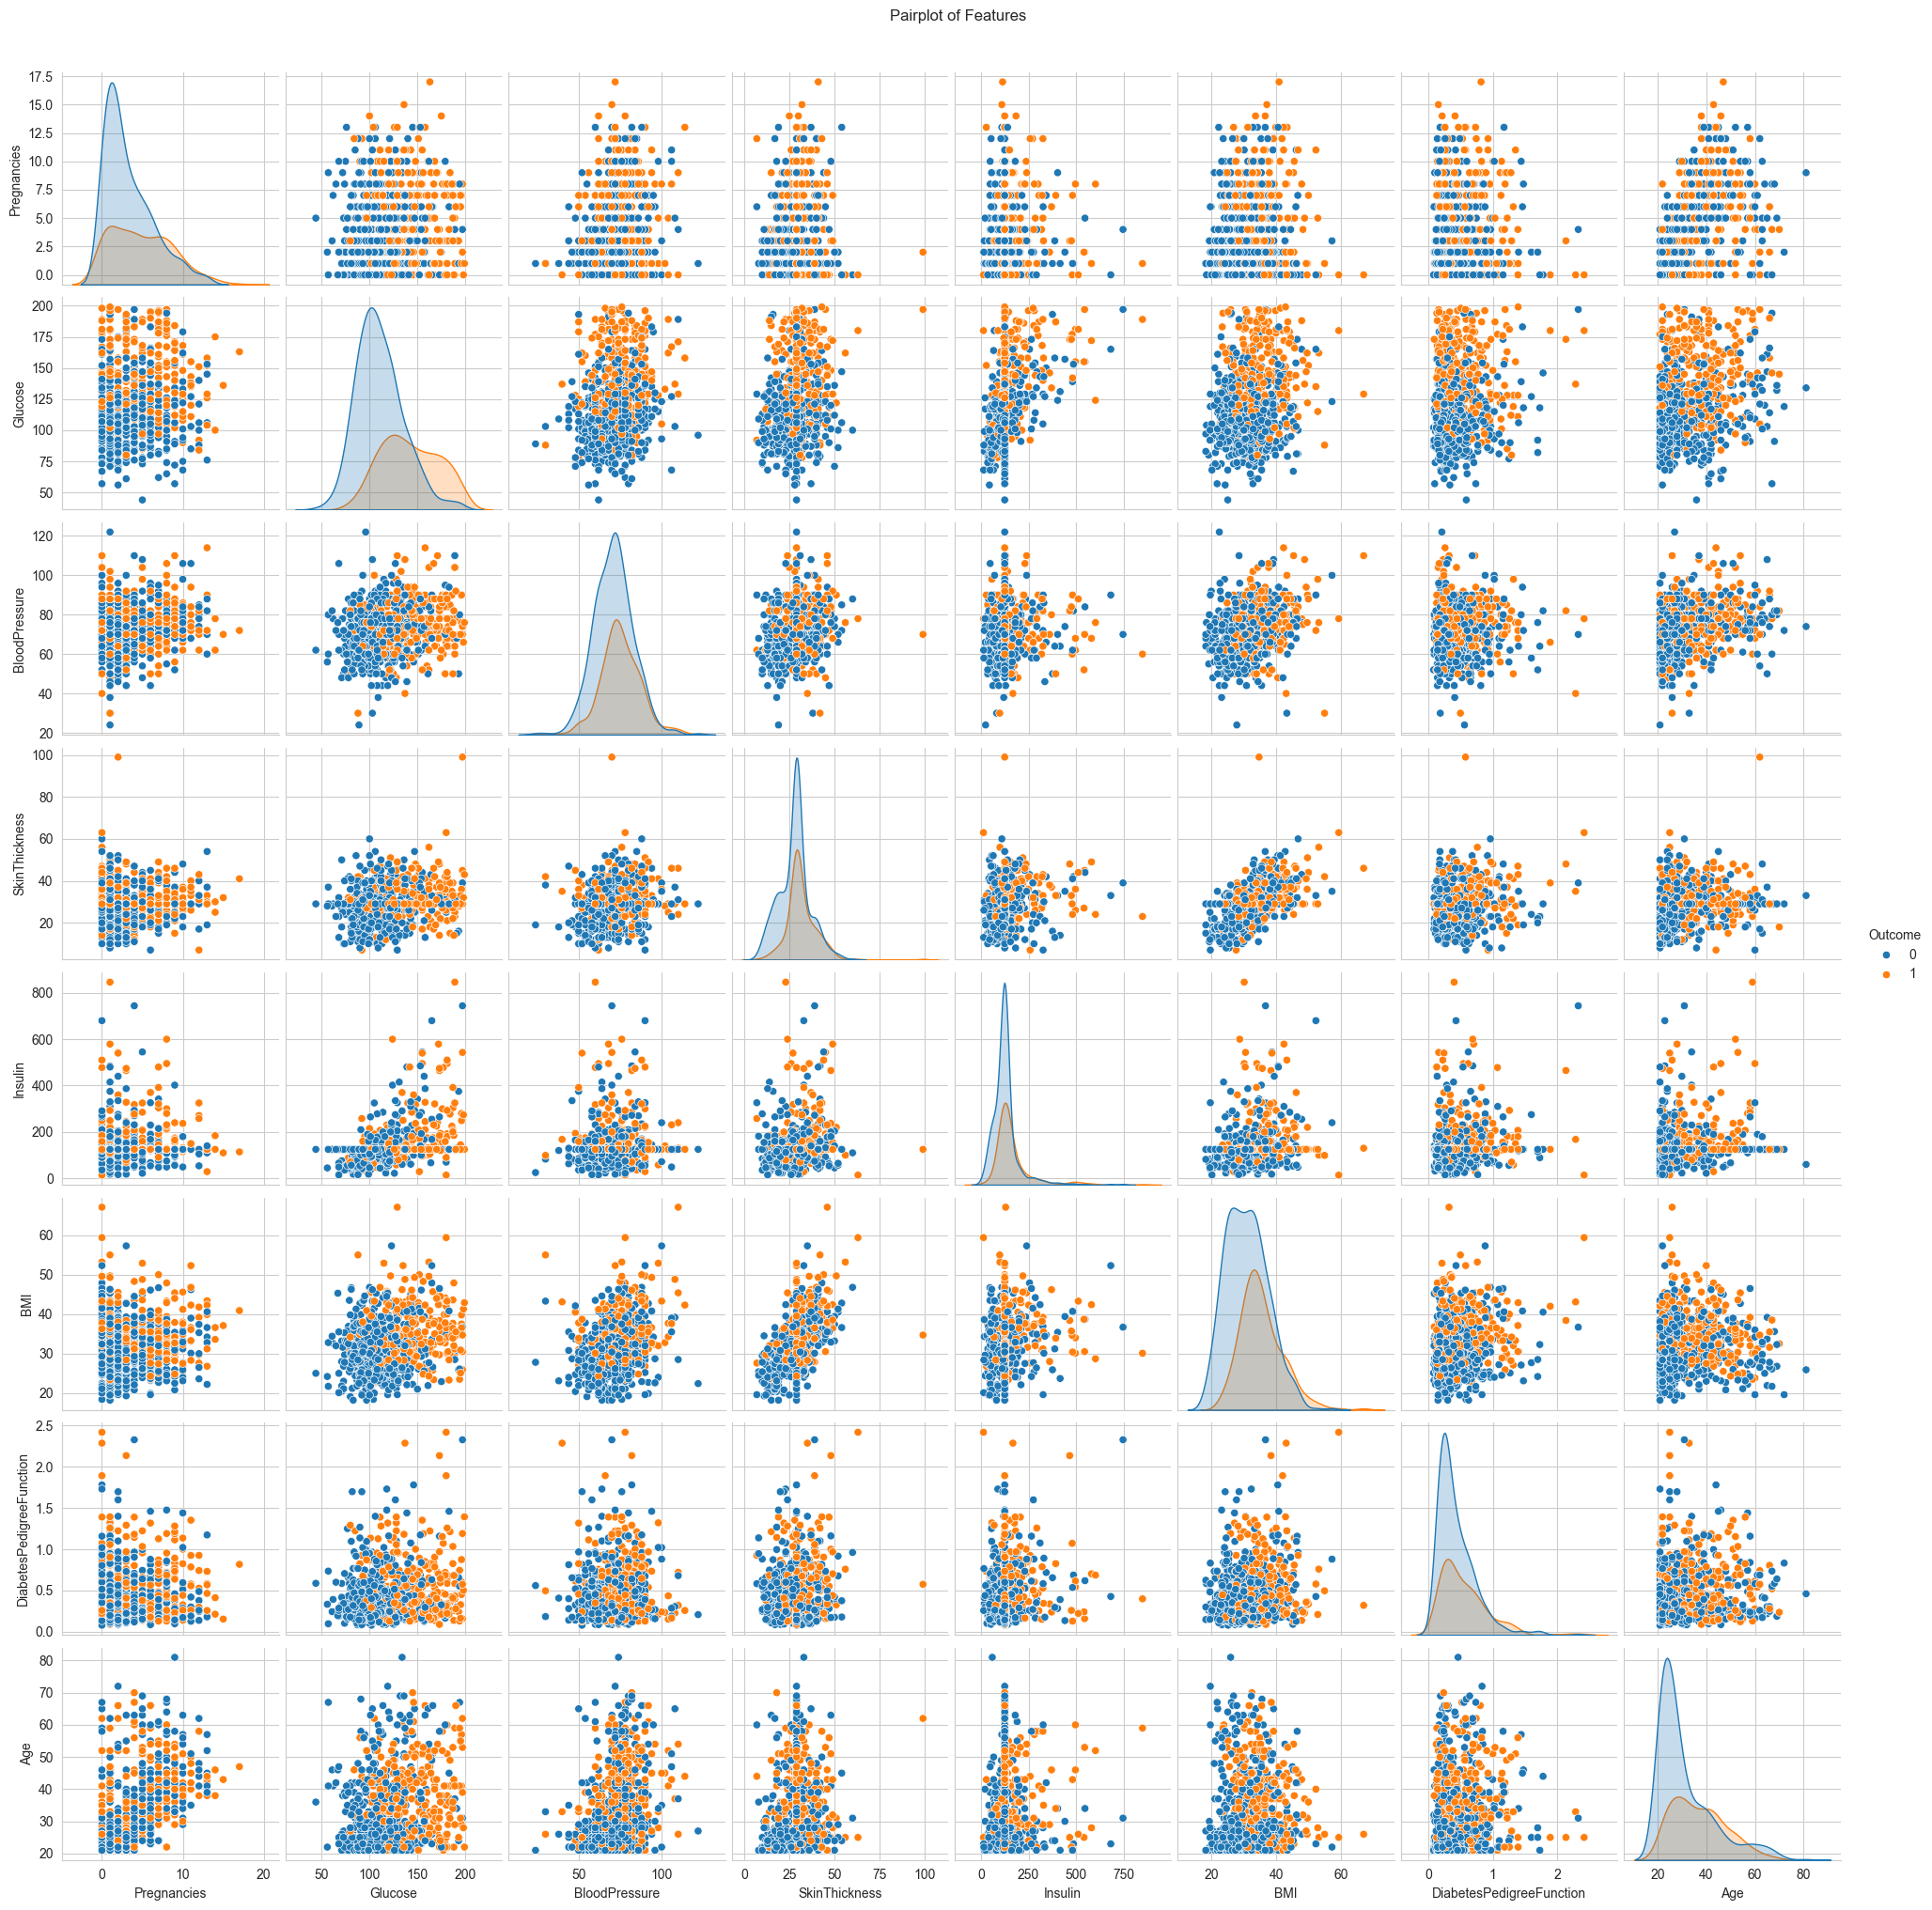


 Logistic Regression
Confusion Matrix:
 [[105  20]
 [ 33  34]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       125
           1       0.63      0.51      0.56        67

    accuracy                           0.72       192
   macro avg       0.70      0.67      0.68       192
weighted avg       0.72      0.72      0.72       192


 Random Forest
Confusion Matrix:
 [[103  22]
 [ 29  38]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       125
           1       0.63      0.57      0.60        67

    accuracy                           0.73       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.73      0.73       192


 XGBoost
Confusion Matrix:
 [[105  20]
 [ 25  42]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       125
           1       0.68      0.63      0.65        67

    accu

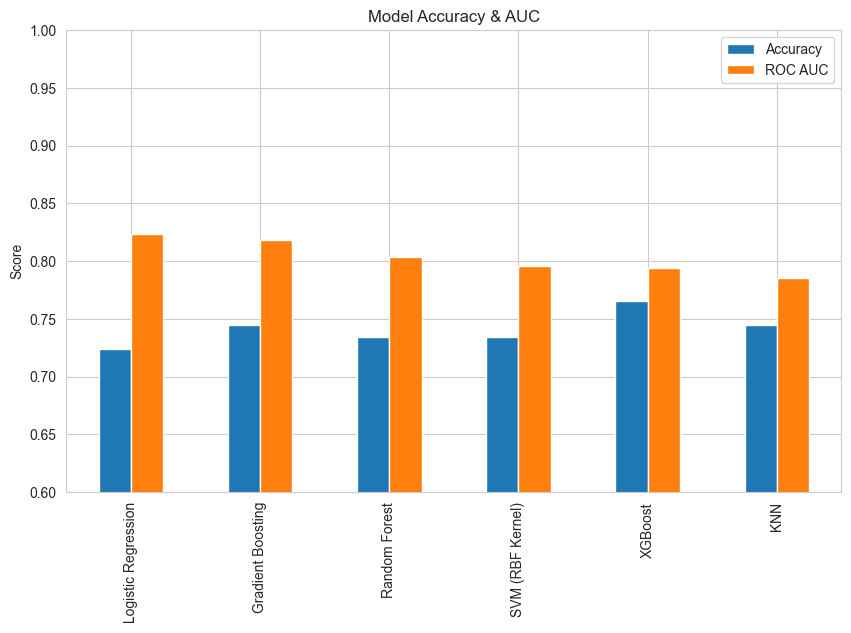

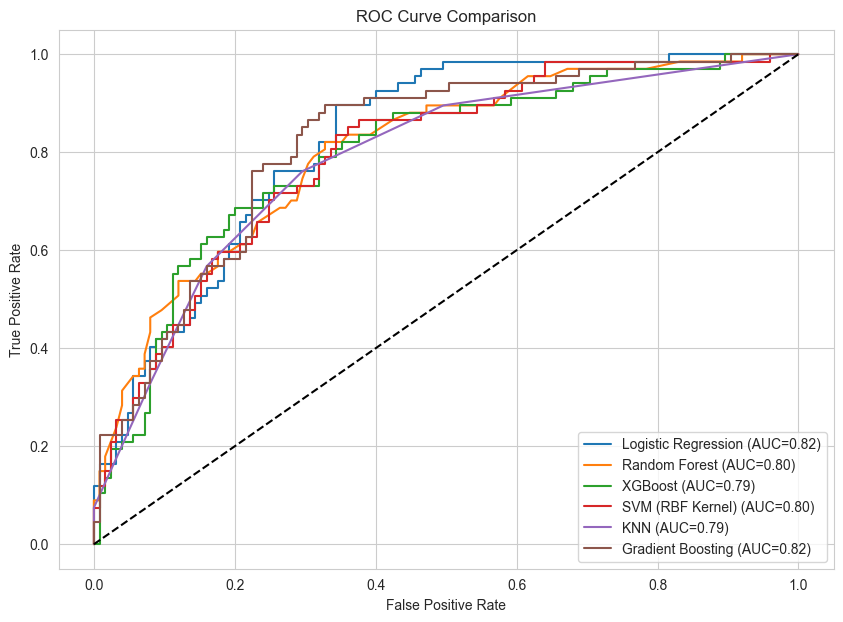

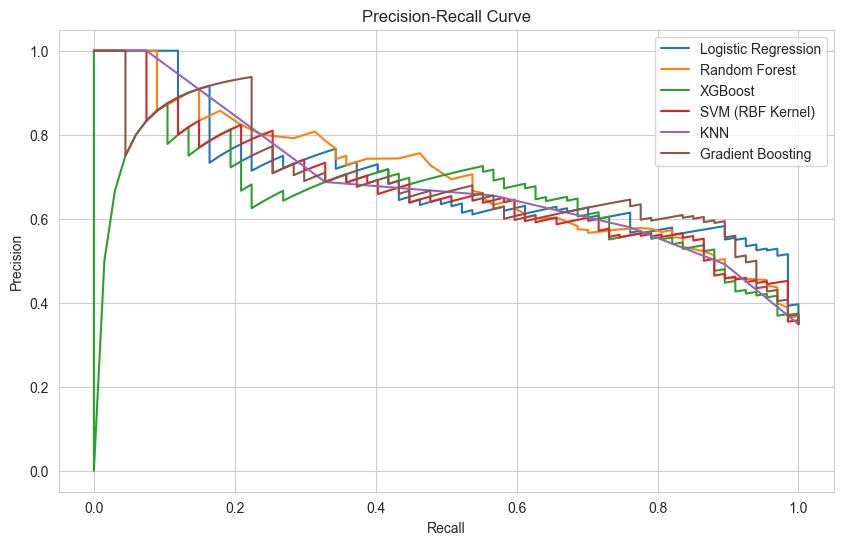

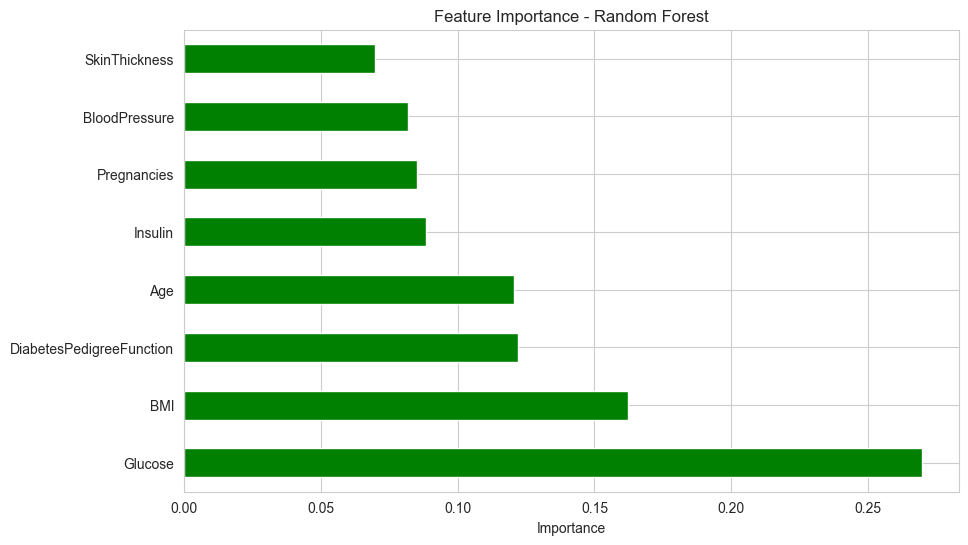

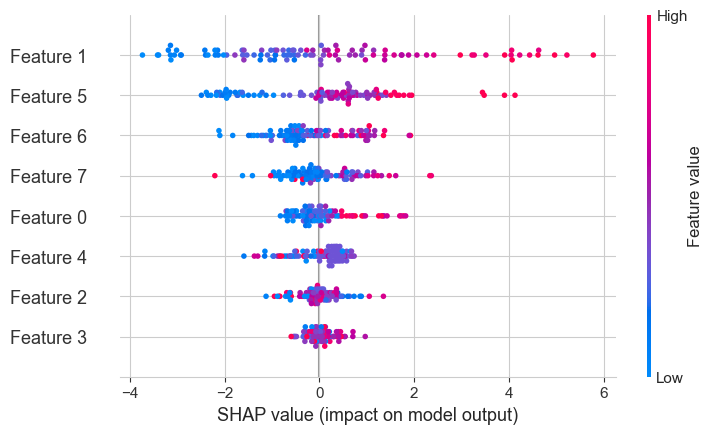


 Cross-Validation AUC (5-fold):
Random Forest: Mean AUC = 0.831 | Std = 0.031
XGBoost: Mean AUC = 0.801 | Std = 0.033
Gradient Boosting: Mean AUC = 0.832 | Std = 0.024


In [19]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

#  Load Dataset
df = pd.read_csv('diabetes.csv')

#  Data Cleaning
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

#  Exploratory Data Analysis
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

sns.pairplot(df, hue="Outcome", diag_kind="kde")
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

#  Features & Target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

#  Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

# ML Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM (RBF Kernel)": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

#  Train & Evaluate Models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"Accuracy": acc, "ROC AUC": auc}

    print(f"\n {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

#  Accuracy & AUC Comparison
result_df = pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False)
result_df.plot(kind="bar", figsize=(10, 6), ylim=(0.6, 1.0), title="Model Accuracy & AUC", grid=True)
plt.ylabel("Score")
plt.show()

#  ROC Curves
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

#  Precision-Recall Curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

#  Feature Importance (Random Forest)
feat_imp = pd.Series(models["Random Forest"].feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind="barh", title="Feature Importance - Random Forest", color="green")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

#  SHAP Values for XGBoost
explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)

#  Cross-Validation AUC
print("\n Cross-Validation AUC (5-fold):")
for name in ["Random Forest", "XGBoost", "Gradient Boosting"]:
    scores = cross_val_score(models[name], X_scaled, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5))
    print(f"{name}: Mean AUC = {scores.mean():.3f} | Std = {scores.std():.3f}")


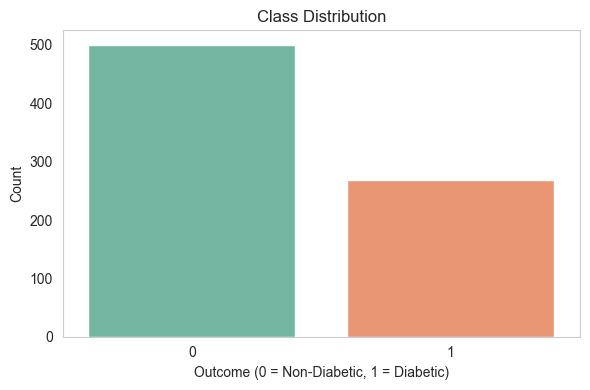

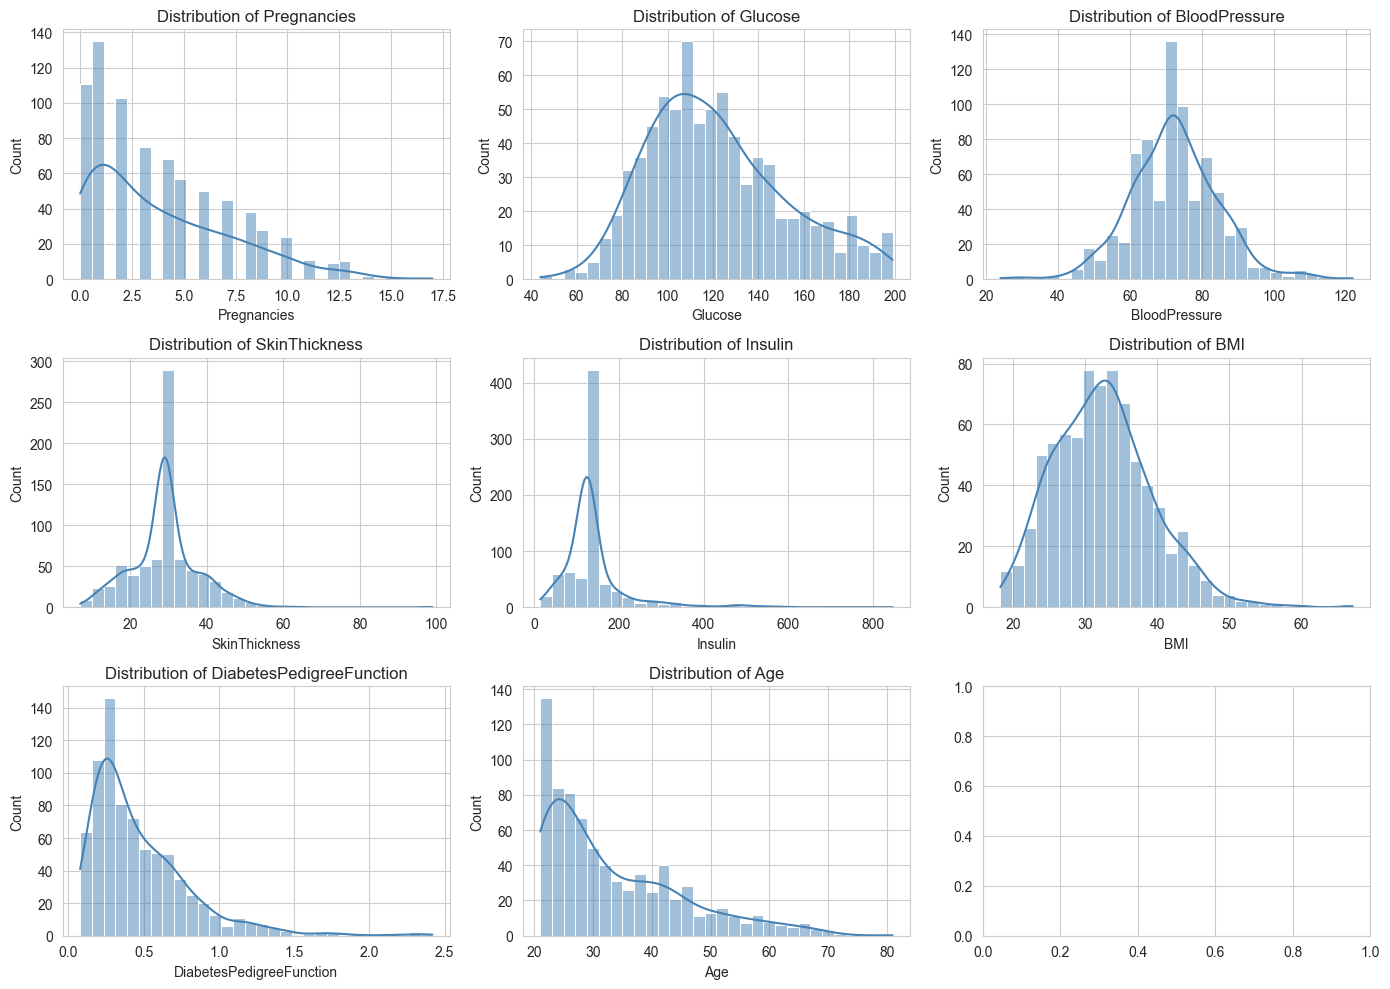

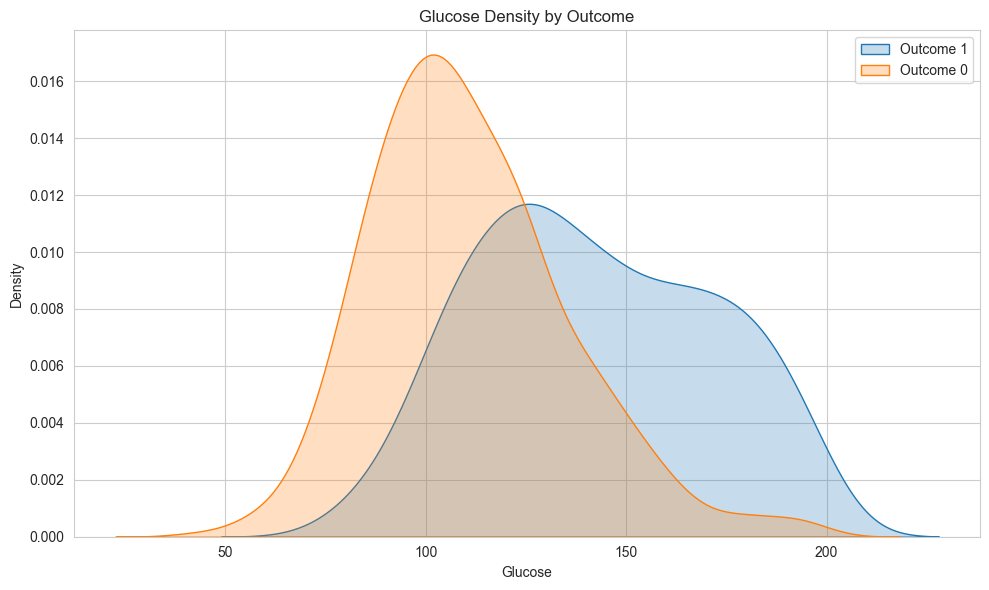

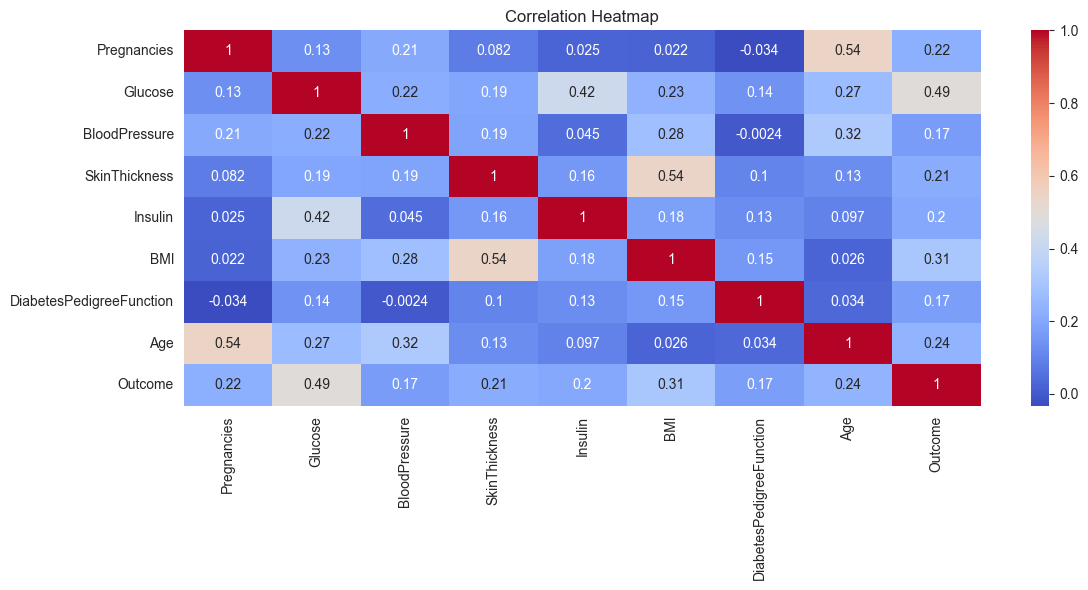

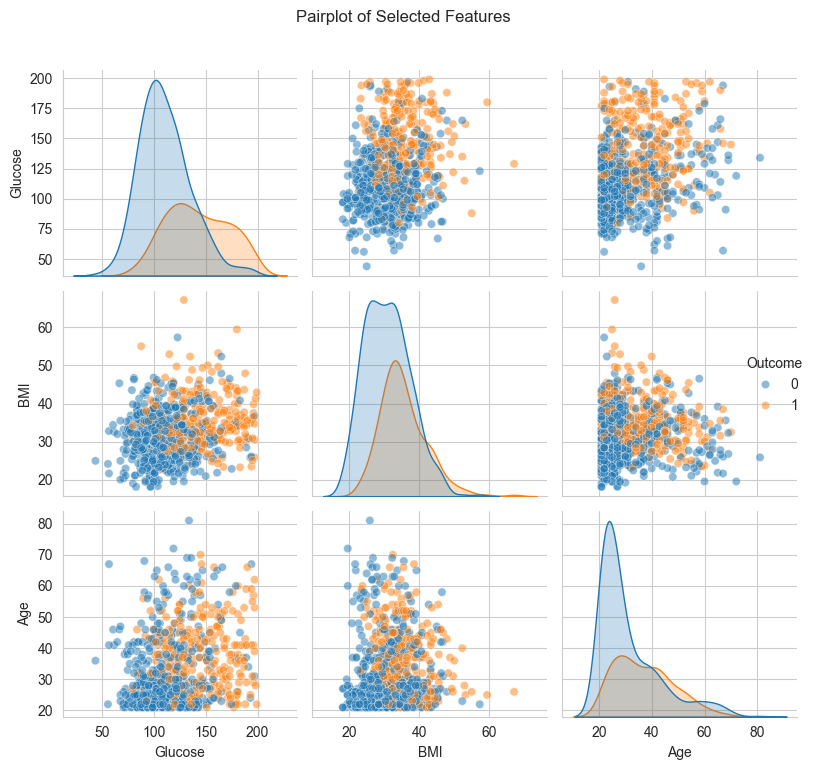

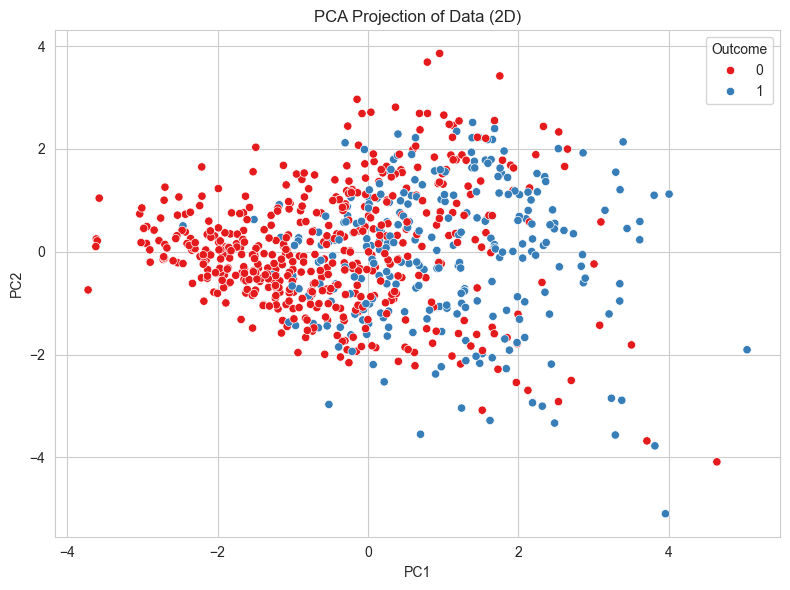


Model: Logistic Regression
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       125
           1       0.63      0.51      0.56        67

    accuracy                           0.72       192
   macro avg       0.70      0.67      0.68       192
weighted avg       0.72      0.72      0.72       192



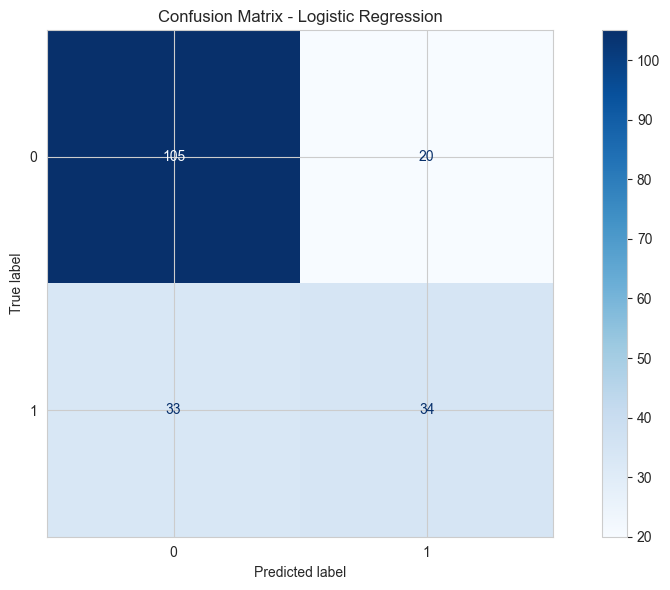


Model: Random Forest
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       125
           1       0.63      0.57      0.60        67

    accuracy                           0.73       192
   macro avg       0.71      0.70      0.70       192
weighted avg       0.73      0.73      0.73       192



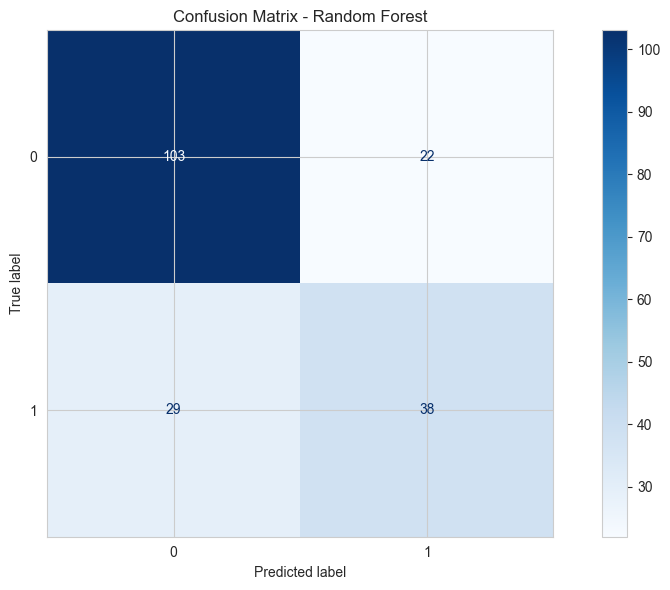


Model: XGBoost
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       125
           1       0.68      0.63      0.65        67

    accuracy                           0.77       192
   macro avg       0.74      0.73      0.74       192
weighted avg       0.76      0.77      0.76       192



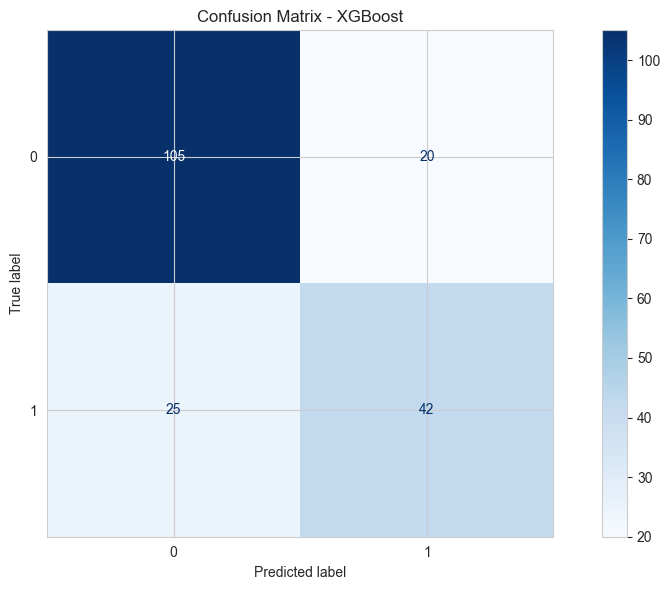


Model: SVM (RBF Kernel)
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       125
           1       0.65      0.52      0.58        67

    accuracy                           0.73       192
   macro avg       0.71      0.69      0.69       192
weighted avg       0.73      0.73      0.73       192



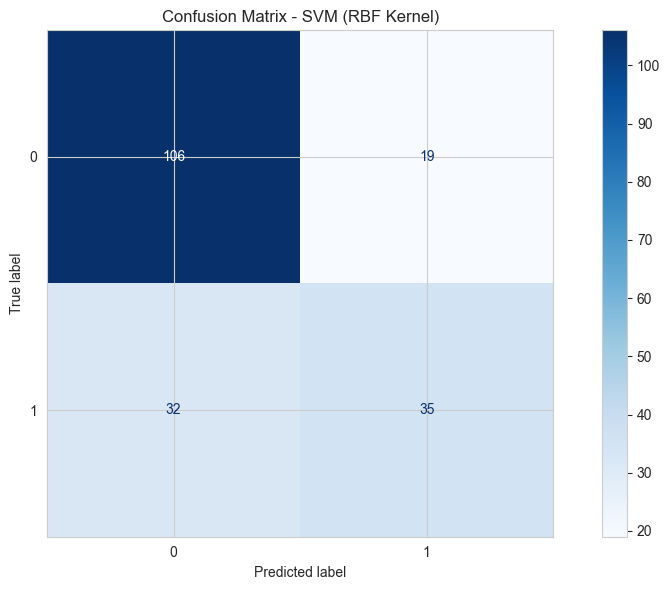


Model: KNN
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       125
           1       0.66      0.57      0.61        67

    accuracy                           0.74       192
   macro avg       0.72      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192



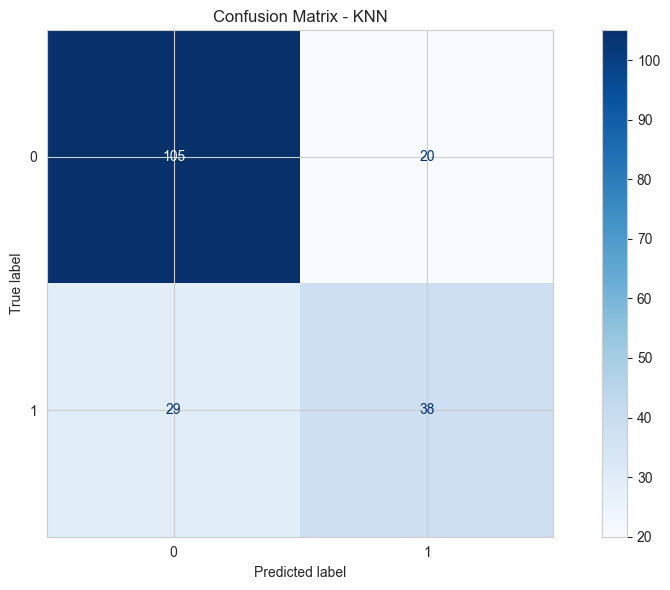


Model: Gradient Boosting
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       125
           1       0.66      0.55      0.60        67

    accuracy                           0.74       192
   macro avg       0.72      0.70      0.71       192
weighted avg       0.74      0.74      0.74       192



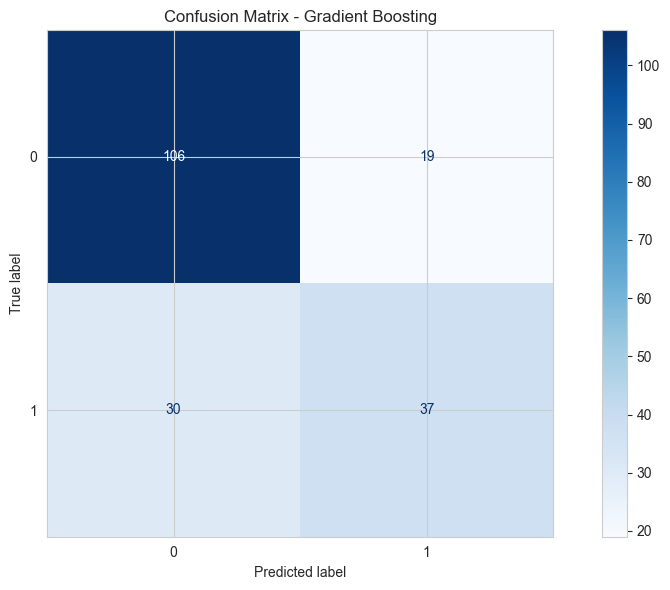

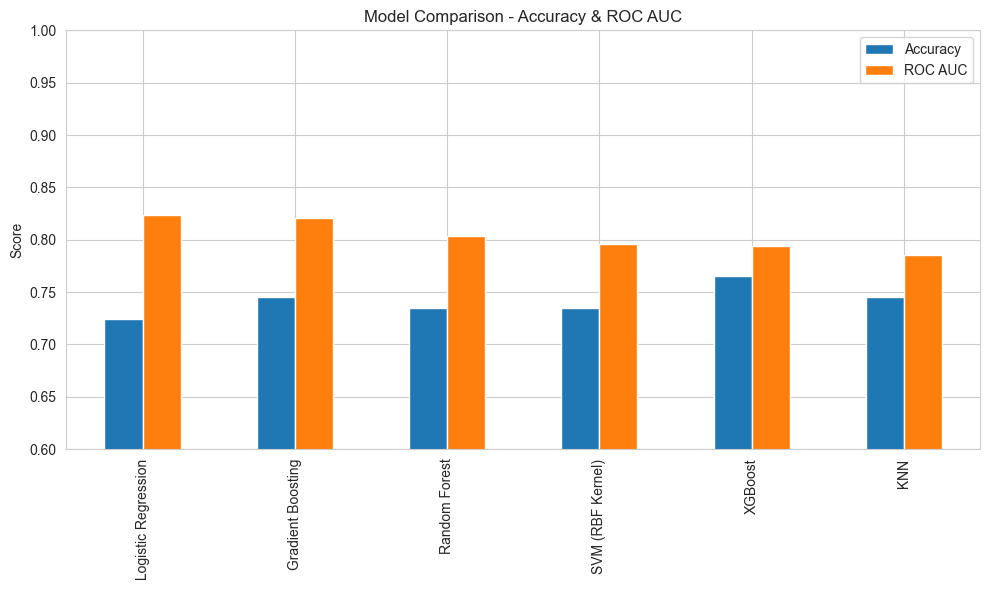

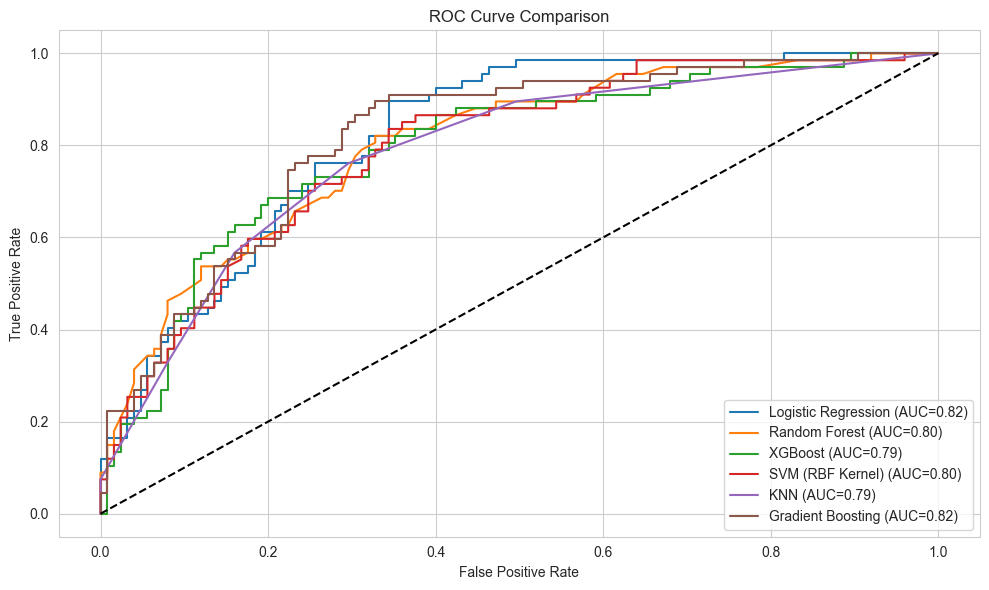

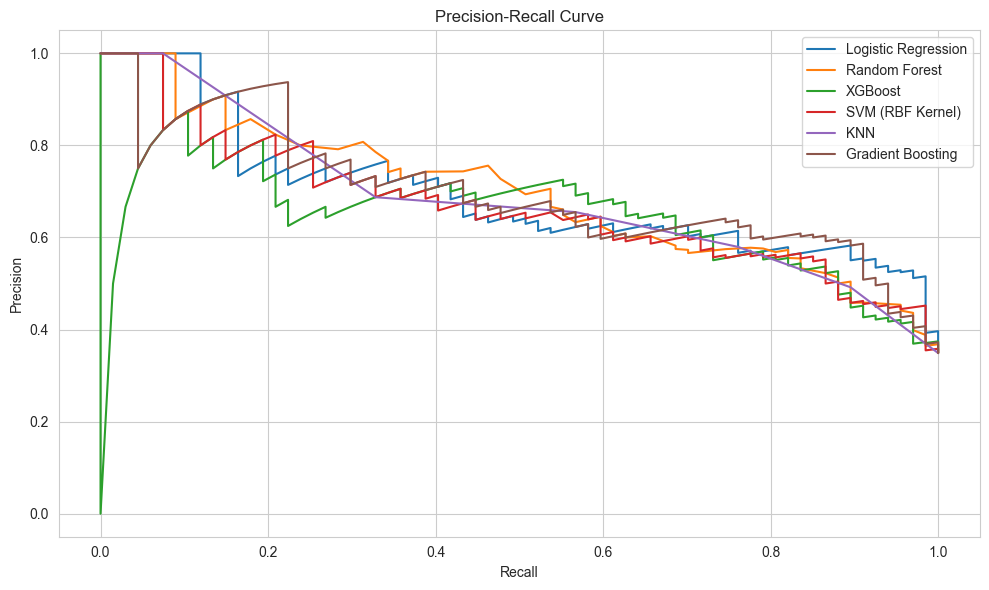

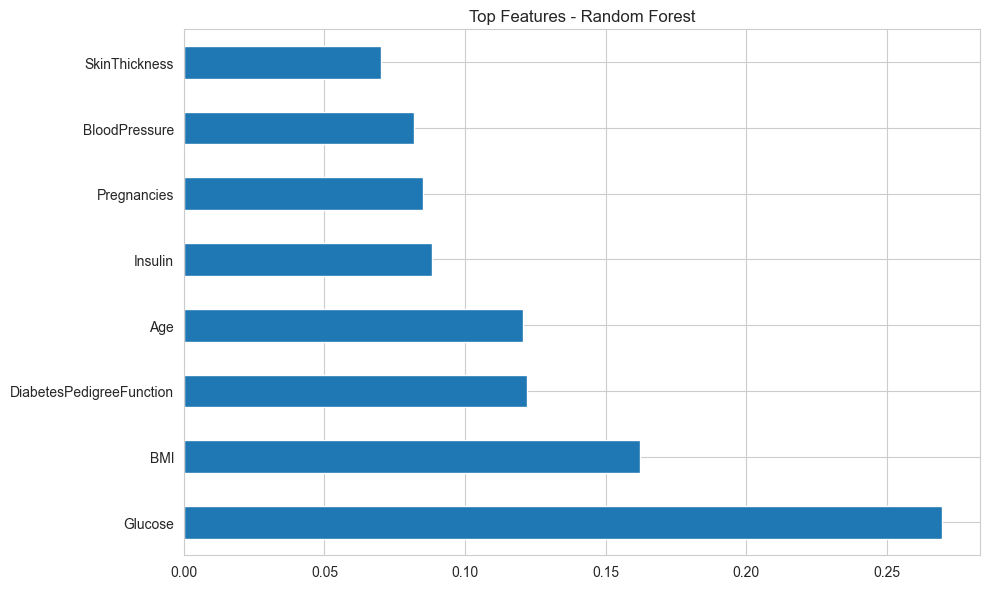

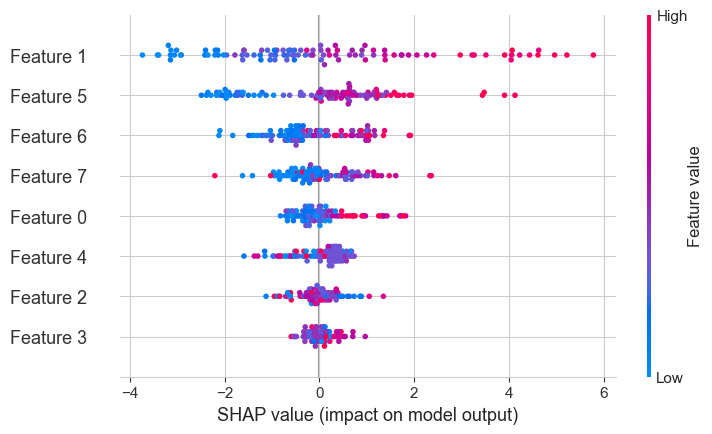

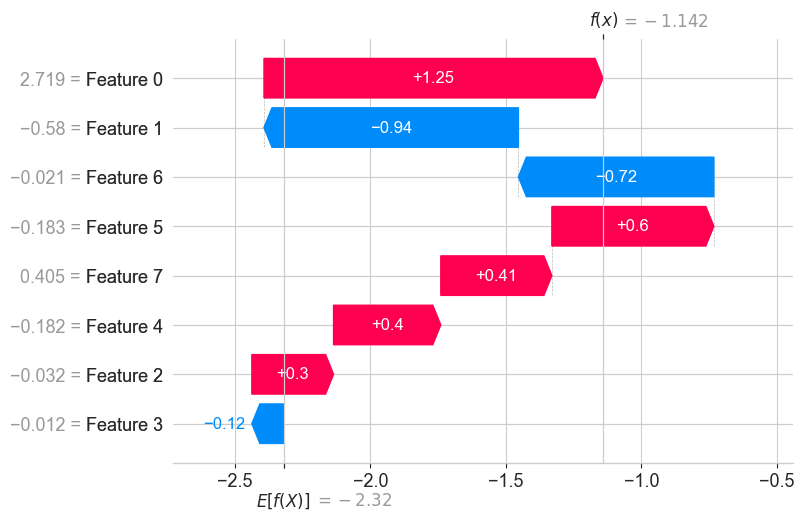


Cross-Validation AUC (5-fold):
Random Forest: Mean AUC = 0.831 | Std = 0.031
XGBoost: Mean AUC = 0.801 | Std = 0.033
Gradient Boosting: Mean AUC = 0.830 | Std = 0.027


In [20]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
df = pd.read_csv('diabetes.csv')

# Data Cleaning
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

# Class Balance
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Feature Distributions
fig, axes = plt.subplots(3, 3, figsize=(14,10))
for i, column in enumerate(df.columns[:-1]):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i//3][i%3], color='steelblue')
    axes[i//3][i%3].set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# KDE by Outcome
plt.figure(figsize=(10,6))
for label in df['Outcome'].unique():
    sns.kdeplot(df[df['Outcome']==label]['Glucose'], label=f"Outcome {label}", fill=True)
plt.title("Glucose Density by Outcome")
plt.xlabel("Glucose")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Pairplot (Subset)
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue="Outcome", diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.tight_layout()
plt.show()

# Feature and Target Split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1')
plt.title("PCA Projection of Data (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.25, random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM (RBF Kernel)": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

# Training & Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"Accuracy": acc, "ROC AUC": auc}
    
    print(f"\nModel: {name}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# Performance Comparison
pd.DataFrame(results).T.sort_values(by="ROC AUC", ascending=False).plot(
    kind="bar", figsize=(10,6), ylim=(0.6, 1.0), grid=True
)
plt.title("Model Comparison - Accuracy & ROC AUC")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10,6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance (Random Forest)
feat_imp = pd.Series(models["Random Forest"].feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind="barh", title="Top Features - Random Forest")
plt.tight_layout()
plt.show()

# SHAP Explainability (XGBoost)
explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values, max_display=10)
shap.plots.waterfall(shap_values[0])

# Cross-Validation
print("\nCross-Validation AUC (5-fold):")
for name in ["Random Forest", "XGBoost", "Gradient Boosting"]:
    scores = cross_val_score(models[name], X_scaled, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5))
    print(f"{name}: Mean AUC = {scores.mean():.3f} | Std = {scores.std():.3f}")

